In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
dates = os.listdir("/media/ubuntu/sda/data/mouse5/output/analysis_natural_image/5000")

cluster_inf = pd.DataFrame()
spike_inf = pd.DataFrame()
waveform_mean = pd.DataFrame()

for date in dates:
    cluster_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse5/output/analysis_natural_image/5000/{date}/cluster_inf.tsv', sep = '\t').iloc[:, 1:]
    cluster_inf_temp['date'] = date
    cluster_inf = pd.concat((cluster_inf, cluster_inf_temp), axis= 0)

    spike_inf_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse5/output/analysis_natural_image/5000/{date}/spike_inf.tsv', sep = "\t").iloc[:, 1:]
    spike_inf_temp['date'] = date
    spike_inf = pd.concat((spike_inf, spike_inf_temp), axis=0)

    waveform_mean_temp = pd.read_csv(f'/media/ubuntu/sda/data/mouse5/output/analysis_natural_image/5000/{date}/waveform_mean.tsv', sep = "\t").iloc[:, 1:]
    waveform_mean_temp.columns = waveform_mean_temp.columns + f"_{date}"
    waveform_mean = pd.concat((waveform_mean, waveform_mean_temp), axis=1)


del waveform_mean_temp, spike_inf_temp, cluster_inf_temp

In [3]:
date_order = ['030222', '042422', '052322', '062322', '082422', '092222','102522', '112822', '122322', '012123', '022423', '032323', '042323',
              '052423', '062323', '072123']

In [18]:
cluster_inf = cluster_inf[cluster_inf['date'] != '072322']
spike_inf = spike_inf[spike_inf['date'] != '072322']

In [19]:
threshold = np.arange(1, 15, 1)
num_neuron = []
for num in threshold:
    cluster_inf['Neuron'] = None
    cluster_inf.iloc[0, 28] = 1
    neuron_inf = pd.DataFrame(cluster_inf.iloc[0, :]).T
    neuron = 1
    for i in range(1, len(cluster_inf)):
        found = False
        for j in range(len(neuron_inf)):
            if (abs(cluster_inf.iloc[i, 22] - neuron_inf.iloc[j, 22]) <= num) and (abs(cluster_inf.iloc[i, 23] - neuron_inf.iloc[j, 23]) <= num):
                cluster_inf.iloc[i, 28] = neuron_inf.iloc[j, 28]
                found = True
                break
        if not found:
            neuron += 1
            cluster_inf.iloc[i,28] = neuron
            neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_inf.iloc[i, :]).T), axis=0)

    neurons_with_count_gt_16 = cluster_inf['Neuron'].value_counts()
    neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()
    num_neuron.append(len(neuron_values))


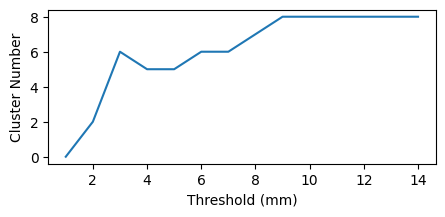

In [20]:
plt.figure(figsize=(5, 2))
sns.lineplot(x = threshold,
                y = num_neuron)
plt.xlabel("Threshold (mm)")
plt.ylabel("Cluster Number")
plt.show()

In [21]:
num = 9
cluster_inf['Neuron'] = None
cluster_inf.iloc[0, 28] = 1
neuron_inf = pd.DataFrame(cluster_inf.iloc[0, :]).T
neuron = 1
for i in range(1, len(cluster_inf)):
    found = False
    for j in range(len(neuron_inf)):
        if (abs(cluster_inf.iloc[i, 22] - neuron_inf.iloc[j, 22]) <= num) and (abs(cluster_inf.iloc[i, 23] - neuron_inf.iloc[j, 23]) <= num):
            cluster_inf.iloc[i, 28] = neuron_inf.iloc[j, 28]
            found = True
            break
    if not found:
        neuron += 1
        cluster_inf.iloc[i,28] = neuron
        neuron_inf = pd.concat((neuron_inf, pd.DataFrame(cluster_inf.iloc[i, :]).T), axis=0)

neurons_with_count_gt_16 = cluster_inf['Neuron'].value_counts()
neuron_values = neurons_with_count_gt_16[neurons_with_count_gt_16 >= 13].index.tolist()

In [22]:
num = 1
neuron_cluster_dict = {}
for neuron in neuron_values:
    temp = cluster_inf[cluster_inf['Neuron'] == neuron]
    filter_cluster = temp.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
    waveform_mean_temp = waveform_mean.loc[:, filter_cluster]

    from sklearn.cluster import DBSCAN
    from sklearn.decomposition import PCA


    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(waveform_mean_temp.T)

    eps = 100
    min_samples = 1

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(principal_components)

    #plt.Figure(figsize=(5, 5))
    #sns.scatterplot(x = principal_components[:, 0],
    #            y = principal_components[:, 1],
    #            hue=dbscan.labels_)
    #plt.title(neuron)
    #plt.show()

    filter_cluster = pd.DataFrame(filter_cluster).reset_index(drop=True)
    filter_cluster = pd.concat((pd.DataFrame(filter_cluster), pd.DataFrame(dbscan.labels_)), axis=1)
    filter_cluster.columns = ['cluster_date', 'dbscan_labels']
    for i in filter_cluster['dbscan_labels'].value_counts().index:
        neuron_cluster_dict[f'Neuron_{num}'] = filter_cluster.loc[filter_cluster['dbscan_labels'] == i, 'cluster_date'].tolist()
        num += 1

In [23]:
len(neuron_cluster_dict)

13

In [24]:
neuron_cluster_dict = {key: value for key, value in neuron_cluster_dict.items() if len(set([item.split('_')[1] for item in value])) >= 13}

In [25]:
cluster_inf['cluster_date'] = cluster_inf.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
cluster_inf = cluster_inf[cluster_inf['cluster_date'].isin([item for sublist in neuron_cluster_dict.values() for item in sublist])]
for key, item in neuron_cluster_dict.items():
    cluster_inf.loc[cluster_inf['cluster_date'].isin(item), 'Neuron'] = key 

spike_inf['cluster_date'] = spike_inf.apply(lambda row: f"{row['cluster']}_{row['date']}", axis=1)
spike_inf = spike_inf[spike_inf['cluster_date'].isin([item for sublist in neuron_cluster_dict.values() for item in sublist])]
for key, item in neuron_cluster_dict.items():
    spike_inf.loc[spike_inf['cluster_date'].isin(item), 'Neuron'] = key 

In [26]:
cluster_inf['Neuron_index'] = cluster_inf['Neuron'].str.extract(r'Neuron_(\d+)').astype(int)
cluster_inf = cluster_inf.sort_values(by='Neuron_index')
cluster_inf['Neuron'] = 'Neuron_' + (cluster_inf['Neuron_index'].rank(method='dense').astype(int)).astype(str)

spike_inf['Neuron_index'] = spike_inf['Neuron'].str.extract(r'Neuron_(\d+)').astype(int)
spike_inf = spike_inf.sort_values(by='Neuron_index')
spike_inf['Neuron'] = 'Neuron_' + (spike_inf['Neuron_index'].rank(method='dense').astype(int)).astype(str)

In [27]:
cluster_inf['neuron_date'] = cluster_inf.apply(lambda row: f"{row['Neuron']}_{row['date']}", axis=1)
spike_inf['neuron_date'] = spike_inf.apply(lambda row: f"{row['Neuron']}_{row['date']}", axis=1)

In [28]:
from scipy.stats import pearsonr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
with PdfPages('cluster_view.pdf') as pdf:
    for neuron in sorted(cluster_inf['Neuron'].unique(), key=lambda x: int(x.split('_')[1])):
        temp = cluster_inf[cluster_inf['Neuron'] == neuron]
        waveform_mean_temp = waveform_mean.loc[:, temp['cluster_date'].tolist()]

        similarity = np.zeros((waveform_mean_temp.shape[1], waveform_mean_temp.shape[1]))
        for i in range(waveform_mean_temp.shape[1]):
            for j in range(waveform_mean_temp.shape[1]):
                similarity[i, j], _ = pearsonr(waveform_mean_temp.iloc[:, i], waveform_mean_temp.iloc[:, j])
        similarity = similarity.flatten()

        cluster_num = len(temp['neuron_date'].value_counts().index)
        blue_palette = sns.color_palette("Blues", n_colors=waveform_mean_temp.shape[1])

        fig, ax = plt.subplots(figsize=(6, 4))
        for i in range(waveform_mean_temp.shape[1]):
            sns.lineplot(x = range(61),
                        y = waveform_mean_temp.iloc[:, i],
                        color=blue_palette[i],
                        ax=ax)
        axins = inset_axes(ax, width="20%", height="30%", loc='lower right', bbox_to_anchor=(-0.03, 0.05, 1, 1), bbox_transform=ax.transAxes)    
        sns.histplot(similarity, color='red', ax=axins, edgecolor = None)
        axins.set_yticks([])
        axins.set_ylabel("")
        axins.set_title("Similarity", fontsize=9)
        axins.tick_params(axis='both', which='major', labelsize=8)

        ax.set_ylabel("Amplitude")
        ax.set_xticks([])
        ax.set_title(neuron)
        ax.text(0.01, 0.95, f'Cluster Number: {cluster_num}', transform=ax.transAxes, fontsize=10, color='black', ha='left')
        pdf.savefig(fig)
        plt.close(fig)


In [30]:
select_neurons = ['Neuron_1', 'Neuron_2', 
                  'Neuron_5', 'Neuron_6', 'Neuron_7']

In [31]:
spike_inf = spike_inf[spike_inf['Neuron'].isin(select_neurons)]
cluster_inf = cluster_inf[cluster_inf['Neuron'].isin(select_neurons)]

In [32]:
neuron_date_dict = {}
for neuron in sorted(cluster_inf['Neuron'].unique(), key=lambda x: int(x.split('_')[1])):
    temp = cluster_inf[cluster_inf['Neuron'] == neuron]
    neuron_date_dict[neuron] = sorted(temp['date'].unique())

In [35]:
trigger_time = pd.read_csv("/media/ubuntu/sda/data/mouse5/output/analysis_natural_image/01_get_trigger/trigger_time.tsv", sep = '\t').iloc[:, 1:]

In [76]:
from scipy.stats import  pearsonr
firing_rate_dict = {}
correlation_dict = {}

firing_rate_dict = {}
correlation_dict = {}

for date in spike_inf['date'].unique():
    spike_inf_temp = spike_inf[spike_inf['date'] == date]
    firing_rate_dict[date] = {}
    trigger_time_temp = trigger_time[trigger_time['date'] == int(date)]
    for image in trigger_time_temp['image'].unique():
        firing_rate_dict[date][image] = pd.DataFrame()
        trigger_time_temp_temp = trigger_time_temp[trigger_time_temp['image'] == image]
        for image_order in trigger_time_temp_temp['order'].sort_index().values.tolist():
            trigger_time_temp_temp_temp = trigger_time_temp_temp[trigger_time_temp_temp['order'] == image_order]
            temp = spike_inf_temp[(spike_inf_temp['time'] > int(trigger_time_temp_temp_temp['start'].values)) & (spike_inf_temp['time'] < int(trigger_time_temp_temp_temp['end'].values))]
            temp_df = pd.DataFrame(temp['Neuron'].value_counts()).sort_index()
            temp_df = temp_df.reindex(firing_rate_dict[date][image].index.union(temp_df.index), fill_value=0)
            firing_rate_dict[date][image] = pd.concat((firing_rate_dict[date][image], temp_df), axis=1)
        firing_rate_dict[date][image] = firing_rate_dict[date][image].fillna(0)

    correlation_dict[date] = {}
    for key in sorted(list(firing_rate_dict[date].keys())):
        num = firing_rate_dict[date][key].shape[1]
        correlation_dict[date][key] = np.zeros((num, num))
        for i in range(num):
            for j in range(num):
                correlation_dict[date][key][i, j], _ = pearsonr(firing_rate_dict[date][key].iloc[:, i].values.tolist(), firing_rate_dict[date][key].iloc[:, j].values.tolist())


In [77]:
outlier = []
for date in correlation_dict.keys():
    for image in range(1, 118):
        mean = (correlation_dict[date][image].sum(axis = 0)-1)/(len(correlation_dict[date][image]) - 1)
        for i in range(len(mean)):
            if mean[i] <= 0.6:
                outlier.append(f'{date}_{image}_{i}')

In [78]:
import pickle
with open('outlier.pkl', 'wb') as f:
    pickle.dump(outlier, f)

In [79]:
correlation_mean = pd.DataFrame()
for date in correlation_dict.keys():
    temp = []
    for image, df in correlation_dict[date].items():
        df = df.mean().mean()
        temp.append(df)
    correlation_mean = pd.concat((correlation_mean, pd.DataFrame(temp, columns=[date])),axis=1)

correlation_mean = correlation_mean[date_order]

In [80]:
with PdfPages("similarity_within_dates.pdf") as pdf:
    mean = correlation_mean.mean(axis=0)
    std = correlation_mean.std(axis=0)

    plt.figure(figsize=(6, 3))
    sns.lineplot(x = range(16),
                 y = mean,
                 color = 'black')
    sns.scatterplot(x = range(16),
                    y = mean,
                    size=30,
                    color = "black",
                    legend=False)
    plt.fill_between(x  = range(16), 
                     y1=mean - std,
                     y2=mean + std,
                     color = 'grey',
                     alpha = 0.2)
    plt.xticks([])
    plt.ylim(0, 1)
    plt.yticks([])
    pdf.savefig()
    plt.close()

In [81]:
with PdfPages('PV_similarity_tight.pdf') as pdf:
    for date in spike_inf['date'].unique():
        fig, axes = plt.subplots(9, 13, figsize=(26, 18))  
        axes = axes.flatten()  
        
        for key in sorted(list(firing_rate_dict[date].keys())):
            ax = axes[key-1]
            sns.heatmap(correlation_dict[date][key], cmap="coolwarm", vmax=1, vmin=0, ax=ax,cbar=False, xticklabels=False, yticklabels=False)
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(0.25)  
                spine.set_color('black')

        fig.suptitle(date, fontsize=30)
        fig.subplots_adjust(wspace=0, hspace=0)

        pdf.savefig(fig)
        plt.close(fig)

In [84]:
cluster_inf.to_csv('cluster_inf.tsv', sep = '\t')
spike_inf.to_csv('spike_inf.tsv', sep = '\t')